Set the Kernel as Python 3.5

In [ ]:
! /anaconda/envs/py35/bin/python -m pip install azure-cognitiveservices-search-imagesearch
! /anaconda/envs/py35/bin/python -m pip install azure-cognitiveservices-vision-customvision
! /anaconda/envs/py35/bin/python -m pip install imutils
! /anaconda/envs/py35/bin/python -m pip install imgaug
! mkdir coremltools
! git clone --recursive https://github.com/apple/coremltools.git
! /anaconda/envs/py35/bin/python -m pip install -U winmltools
! /anaconda/envs/py35/bin/python -m pip install -e coremltools/

CustomVision.ai is a service from Microsoft that builds an image classifier using a transfer learning technique to produce a model that can be consumed via a webservice end point or exported as a compact model and used disconnected on a mobile or windows device. 

To avoid overfitting and increase the size of the training dataset you can use image augmentation techniques. 

The image search service can source a set of images to train your classifier.

In [1]:
import platform 

from azure.cognitiveservices.search.imagesearch import ImageSearchAPI
from azure.cognitiveservices.search.imagesearch.models import ImageType, ImageAspect, ImageInsightModule
from msrest.authentication import CognitiveServicesCredentials

import os
import shutil

import urllib.request
import uuid

from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageOps
%matplotlib inline

import cv2
import numpy as np

from imutils import paths
from glob import glob
import skimage.io as io

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models
from azure.cognitiveservices.vision.customvision.training import training_api
from azure.cognitiveservices.vision.customvision.training.models import ImageUrlCreateEntry

import imgaug as ia
from imgaug import augmenters as iaa

from random import randint
import time

from sklearn.metrics import classification_report
import itertools

from coremltools.models.utils import load_spec
from winmltools import convert_coreml
from winmltools.utils import save_model

import yaml

In [2]:
"""
Create a file config.yml in the python folder containing your microsoft text translator key

credentials:
    training_key:                   # your customvision.ai training key 
    prediction_key:                 # your customvision.ai prediction key 
    subscription_key:               # your bing image search key - get a key from https://azure.microsoft.com/en-us/try/cognitive-services/?api=bing-image-search-api
"""

#with open(os.path.join(os.path.dirname(os.path.abspath(__file__)),"config.yml"), 'r') as ymlfile:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

credentials = cfg['credentials']
training_key = credentials['training_key'] # your customvision.ai training key 
prediction_key = credentials['prediction_key'] # your customvision.ai prediction key 
subscription_key = credentials['subscription_key'] # your bing image search key - get a key from https://azure.microsoft.com/en-us/try/cognitive-services/?api=bing-image-search-api

In [3]:
projectName = "catdog"
# format is ["Search Term", "TagName"]
#labelSet = (["sulphur crested","cockatoo"],  ["fantail bird","fantail"], ["kaka parrot","kaka"], ["kea parrot","kea"], ["kakapo","kakapo"], ["kiwi bird","kiwi"], ["kokako bird","kokako"], ["morepork bird","morepork"], ["tui bird","tui"])
labelSet = (["cat","cat"],  ["dog","dog"])

num_augmentations = 3 # how many sets of image augmentations do you want to perform? A larger number will take longer and potentially reduce recall but will also reduce the risk of overfitting

num_images = 50 # this is just for quick testing I recommend choosing 150 for a real project
page_size = 25 # this is just for quick testing I recommend choosing 50 for a real project
final_dim = 299 # width and height to resize the image to 299x299
minWH=300 #minimum image size to return from bing image search

In [4]:
dataFolderName = 'data'
imageFolderName = projectName+'_images'
splitFolderName = projectName+'_images_test_train'
sep = '\\' #use for Windows
if (platform.system()=='Linux'):
    sep = '/'

testDirName = 'test'
trainDirName = 'train'
validDirName = 'valid'
modelDirName = 'model'

project_id="" # leave this blank unless you are working against an existing project in customvision.ai
iteration_id = "" # leave this blank unless you are working against an existing training set in customvision.ai

offset = 0

img_dir = dataFolderName+sep+imageFolderName
test_train_dir = dataFolderName+sep+splitFolderName
test_dir = test_train_dir+sep+testDirName
train_dir = test_train_dir+sep+trainDirName
valid_dir = test_train_dir+sep+validDirName
model_dir = test_train_dir+sep+modelDirName

In [5]:
client = ImageSearchAPI(CognitiveServicesCredentials(subscription_key))

In [6]:
# remove and recreate the training directories
if os.path.exists(img_dir):
    shutil.rmtree(img_dir, ignore_errors=True)

os.makedirs(img_dir)

In [7]:
for (i, searchLabel) in enumerate(labelSet):
    offset = 0
    x = 0
    
    dir_Nm = searchLabel[1]
    print(dir_Nm)
    
    full_dir_Nm = img_dir+sep+dir_Nm
    if not os.path.exists(full_dir_Nm):
        os.makedirs(full_dir_Nm)
        
    max_images = num_images
    
    #https://docs.microsoft.com/en-au/rest/api/cognitiveservices/bing-images-api-v7-reference
    
    while (offset < max_images):
        image_results = client.images.search(
            query=searchLabel[0],
            image_type=ImageType("Photo"), 
            minWidth=str(minWH),
            minHeight=str(minWH),
            count=str(page_size),
            offset=str(offset)
            #,aspect=ImageAspect("Square")
            #,license=License("Public") #When doing this be aware of the license of the underlying images and set the flag on the api appropriately.
        )

        if image_results.value:
            if (image_results.total_estimated_matches<max_images):
                max_images = image_results.total_estimated_matches
            offset=offset+page_size
            
            for img in image_results.value:
                x = x+1
                with urllib.request.urlopen(img.thumbnail_url) as response, open(full_dir_Nm+sep+uuid.uuid4().hex+".jpg", 'wb') as out_file:
                    data = response.read() # a `bytes` object
                    out_file.write(data)
                if x > 0 and x % 100 == 0:
                    print("[INFO] processed {}/{}".format(x, max_images))
        else:
            print("Couldn't find image results!")
            offset = max_images

cat
dog


In [8]:
def makeThumb(image, pad=True):
    size=(final_dim,final_dim)
    image.thumbnail(size, Image.ANTIALIAS)
    image_size = image.size

    if pad:
        thumb = image.crop( (0, 0, size[0], size[1]) )
        offset_x = int(max( (size[0] - image_size[0]) / 2, 0 ))
        offset_y = int(max( (size[1] - image_size[1]) / 2, 0 ))
        thumb = ImageChops.offset(thumb, offset_x, offset_y)
    else:
        thumb = ImageOps.fit(image, size, Image.ANTIALIAS, (0.5, 0.5))

    return thumb

In [9]:
def resize_eq(im_pth):
    im_pth = str(im_pth)
    
    img = cv2.imread(im_pth)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    img = Image.fromarray(img_output, 'RGB')
    
    img = makeThumb(img, pad=True)
    img.save(im_pth)
    
    #img = Image.open(im_pth)
    #img = ImageOps.expand(img, border=border, fill='white')
    #img = ImageOps.fit(img, size=(final_dim,final_dim))
    #img = ImageOps.equalize(img)

In [10]:
pathlist = Path(img_dir).glob('**/*.jpg')
for path in pathlist:
    resize_eq(path)

In [11]:
imagePaths = list(paths.list_images(img_dir))

categories = [item[len(img_dir)+1:-1] for item in sorted(glob(img_dir+sep+"*"+sep))]
print('There are %d total categories.' % len(categories))
print(categories)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

#create the categories in the train and test directory if they don't exist
for (c) in enumerate(categories):
    if not os.path.exists(test_dir+sep+str(c[1])):
        os.makedirs(test_dir+sep+str(c[1]))
    if not os.path.exists(train_dir+sep+str(c[1])):
        os.makedirs(train_dir+sep+str(c[1]))
    if not os.path.exists(valid_dir+sep+str(c[1])):
        os.makedirs(valid_dir+sep+str(c[1]))

ic = io.ImageCollection(glob(img_dir+sep+"*"+sep+"*.jpg"))
print('There are %d total images.' % len(ic))

There are 2 total categories.
['cat', 'dog']
There are 100 total images.


In [12]:
imagePaths = list(paths.list_images(img_dir))

# initialize the data matrix and labels list
data = []
labels = []

In [13]:
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    
    data.append(image.flatten())
    labels.append(label)
    
    # show an update every 500 images
    if i > 0 and i % 500 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))

In [14]:
# encode the labels, converting them from strings to integers
le = LabelEncoder()
labels = le.fit_transform(labels)

In [15]:
# partition the data into training and testing splits, using 80%
# of the data for training and the remaining 20% for testing
print("[INFO] constructing training/testing split...")
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(data), labels, test_size=0.20, random_state=21)

[INFO] constructing training/testing split...


In [21]:
# https://docs.microsoft.com/en-us/python/api/azure.cognitiveservices.vision.customvision?view=azure-python

trainer = training_api.TrainingApi(training_key)

domains = trainer.get_domains()
domain_id = ''
for (i, domain) in enumerate(domains):
    if domain.name=='General (compact)':  #General (compact) domain - exportable
        domain_id = domain.id

# Create a new project
if (project_id==""):
    project = trainer.create_project(projectName, domain_id=domain_id)
    project_id = project.id
    print("Created Project - "+project.name+" : "+project.id)


Created Project - catdog : 3c42ae86-20be-4874-8fb2-8349fe727ae2


In [22]:
def createSetTag(label):
    if (tags[label] is None):
        tags[label] = trainer.create_tag(project_id, label)

In [23]:
tags = dict((l,None) for l in categories)
for i in range(len(categories)):
    createSetTag(str(categories[i]))

In [24]:
# use this if you would like to augment your imageset to increase the number of examples
def augmentImages(trainSet):
    ia.seed(randint(0,99))

    seq = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontal flips 50% of the images
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.ContrastNormalization((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order

    images_aug = seq.augment_images(trainSet)
    return images_aug

In [25]:
def uploadTrainingSet(trainData):

    for (i, data) in enumerate(trainData):
        tagname = str(le.classes_[trainLabels[i]])
        imagePath = train_dir+sep+tagname+sep+uuid.uuid4().hex+".jpg"
        out = Image.fromarray(data.reshape(final_dim,final_dim,3),"RGB").save(imagePath)
        with open(os.fsdecode(imagePath), mode="rb") as img_data: 
            trainer.create_images_from_data(project.id, img_data.read(), [ tags[tagname].id ])

        # show an update every 100 images
        if i > 0 and i % 100 == 0:
            print("[INFO] processed {}/{}".format(i, len(trainData)))

In [26]:
uploadTrainingSet(trainData)

In [27]:
i = 0
while(i < num_augmentations):
    print("[INFO] augmentation number {}/{}".format((i+1), num_augmentations))
    images_aug = augmentImages(trainData.reshape(len(trainData),final_dim,final_dim,3))
    uploadTrainingSet(images_aug) #upload the augmented data set
    i += 1

[INFO] augmentation number 1/3
[INFO] augmentation number 2/3
[INFO] augmentation number 3/3


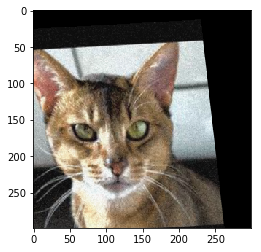

In [28]:
# take a look at the first augmented image in the set
#for (i, data) in enumerate(images_aug):
aug_img = Image.fromarray(images_aug[0],"RGB")
plt.imshow(aug_img)

In [29]:
print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status == "Training"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# The iteration is now trained. Make it the default project endpoint
trainer.update_iteration(project.id, iteration.id, is_default=True)
iteration_id = iteration.id
print ("Done!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done!


	cat: 100.00%
	dog: 0.00%


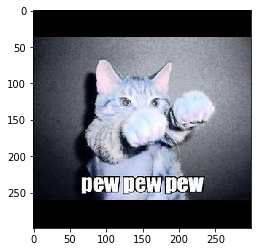

In [56]:
testFileName = img_dir+sep+'test.jpg'
test_img_url = 'http://images1.fanpop.com/images/image_uploads/Funny-Cat-Pictures-cats-935656_500_375.jpg' # sample cat image
#test_img_url = 'http://www.petmeds.org/wp-content/uploads/2012/01/7247801_081708_DSC_0937.jpg' # sample dog image
with urllib.request.urlopen(test_img_url) as response, open(testFileName, 'wb') as out_file:
        data = response.read() # a `bytes` object
        out_file.write(data)
        
resize_eq(testFileName)

plt.imshow(Image.open(testFileName))

# Now there is a trained endpoint that can be used to make a prediction
predictor = prediction_endpoint.PredictionEndpoint(prediction_key)

# Open the sample image and get back the prediction results.
with open(testFileName, mode="rb") as test_data:
    results = predictor.predict_image(project_id, test_data.read(), iteration_id)

# Display the results.
for prediction in results.predictions:
    print ("\t" + prediction.tag + ": {0:.2f}%".format(prediction.probability * 100))

In [31]:
y_actu = []
y_pred = []
miscalc = 0

for (i, data) in enumerate(testData):
    tagname = le.classes_[testLabels[i]]
    imagePath = test_dir+sep+tagname+sep+uuid.uuid4().hex+".jpg"
    out = Image.fromarray(data.reshape(final_dim,final_dim,3),"RGB").save(imagePath)
    with open(os.fsdecode(imagePath), mode="rb") as img_data: 
        results = predictor.predict_image(project_id, img_data.read(), iteration_id)
        y_pred.append(le.classes_.tolist().index(results.predictions[0].tag))
        y_actu.append(testLabels[i])
        if (results.predictions[0].tag!=tagname):
            miscalc = miscalc+1
        
    #if os.path.isfile(imagePath):
    #    os.remove(imagePath)
        
    # show an update every 100 images
    if i > 0 and i % 100 == 0:
        #print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        print("[INFO] processed {}/{}".format(i, len(testData)))

print(miscalc)
print(1-(miscalc/len(testData)))

1
0.95


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

        cat       1.00      0.92      0.96        12
        dog       0.89      1.00      0.94         8

avg / total       0.96      0.95      0.95        20

Normalized confusion matrix
[[0.92 0.08]
 [0.   1.  ]]


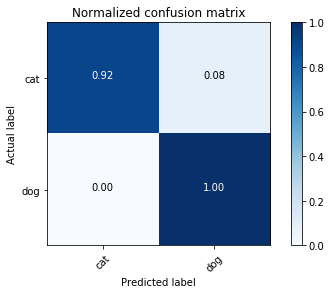

In [33]:
print(classification_report(y_actu, y_pred, target_names=le.classes_))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_actu, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=le.classes_, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [34]:
#https://docs.microsoft.com/en-us/python/api/azure.cognitiveservices.vision.customvision?view=azure-python
    
modelNm = uuid.uuid4().hex+".mlmodel"
onnxNm = uuid.uuid4().hex+".onnx"
tfModelNm = uuid.uuid4().hex+".zip"
dockerModelNm = uuid.uuid4().hex+".zip"
exports = trainer.get_exports(project_id, iteration_id)

#if (len(exports)==0):
    # no model has been exported yet we need to export coreml, Tensorflow and onnx models.
print("Building CoreML Model")
trainer.export_iteration(project_id, iteration_id, 'CoreML')
print("Building Tensorflow Model")
trainer.export_iteration(project_id, iteration_id, 'TensorFlow')
print("Building ONNX Model")
trainer.export_iteration(project_id, iteration_id, 'ONNX')


Building CoreML Model
Building Tensorflow Model
Building ONNX Model


In [ ]:
#trainer.export_iteration(project_id, iteration_id, 'DockerFile') need to figure out how to create DockerFile and choose platform Windows or Linux programatically

In [36]:
exports = trainer.get_exports(project_id, iteration_id)
for (i, export) in enumerate(exports):
    print(export.platform)

CoreML
TensorFlow
ONNX
DockerFile


In [37]:
for (i, export) in enumerate(exports):
    if(export.status=='Done'):
        if(export.platform=='CoreML'):
            print('writing file {}'.format(model_dir+sep+modelNm))
            with urllib.request.urlopen(export.download_uri) as response, open(model_dir+sep+modelNm, 'wb') as out_file:
                data = response.read() # a `bytes` object
                out_file.write(data)
        if(export.platform=='TensorFlow'):
            print('writing file {}'.format(model_dir+sep+tfModelNm))
            with urllib.request.urlopen(export.download_uri) as response, open(model_dir+sep+tfModelNm, 'wb') as out_file:
                data = response.read() # a `bytes` object
                out_file.write(data)
        if(export.platform=='ONNX'):
            print('writing file {}'.format(model_dir+sep+onnxNm))
            with urllib.request.urlopen(export.download_uri) as response, open(model_dir+sep+onnxNm, 'wb') as out_file:
                data = response.read() # a `bytes` object
                out_file.write(data)
        if(export.platform=='DockerFile'):
            print('writing file {}'.format(model_dir+sep+dockerModelNm))
            with urllib.request.urlopen(export.download_uri) as response, open(model_dir+sep+dockerModelNm, 'wb') as out_file:
                data = response.read() # a `bytes` object
                out_file.write(data)

writing file data\catdog_images_test_train\model\894bc4a4b0c44dbe9a6ee9ed6a0e4a35.mlmodel
writing file data\catdog_images_test_train\model\23a2eb122eb245bca73e30228eef1008.zip
writing file data\catdog_images_test_train\model\1222fc0361784acfa6f8efa2f612342e.onnx
writing file data\catdog_images_test_train\model\4008babbd700424fbe59897bfab196ec.zip


In [ ]:
onnxNm = model_dir+sep+modelNm.replace(".mlmodel", ".onnx")

# Load model file
model_coreml = load_spec(model_dir+sep+modelNm)

# Convert it!
# The automatic code generator (mlgen) uses the name parameter to generate class names.
model_onnx = convert_coreml(model_coreml, name=projectName+'Model')

# Save the produced ONNX model in binary format
print('writing file {}'.format(onnxNm))
save_model(model_onnx, onnxNm)

In [38]:
import zipfile
tf_model_dir = format(os.path.join(model_dir,"TensorFlow")) 
zip_ref = zipfile.ZipFile(model_dir+sep+tfModelNm, 'r')
zip_ref.extractall(tf_model_dir)
zip_ref.close()


In [39]:
doc_model_dir = format(os.path.join(model_dir,"Docker")) 
zip_ref = zipfile.ZipFile(model_dir+sep+dockerModelNm, 'r')
zip_ref.extractall(doc_model_dir)
zip_ref.close()


In [41]:
print(format(os.path.join(tf_model_dir,"app","model.pb")) )

data\catdog_images_test_train\model\TensorFlow\app\model.pb


## Mean Values (RGB)
Depending on the [CustomVision.ai](https://CustomVision.ai) model's Domain, you'll need to set the appropriate values within the code:

| Project's Domain | Mean Values (RGB) |
|----|----|
|General (Compact) | (123, 117, 104) |
| Landmark (Compact) | (123, 117, 104) |
| Retail (Compact) | (0, 0, 0) |

These are set in BGR eg:

```
// General (Compact) 
// Landmark (Compact)
var bgrValues = new TFTensor(new float[] { 104.0f, 117.0f, 123.0f });
```

Update 7th May 2018 - For newly trained models exported to TensorFlow in the General (Compact) and Landmark (Compact) Domains, Mean Values are now (0,0,0), for consistency accross all projects. https://docs.microsoft.com/en-au/azure/cognitive-services/Custom-Vision-Service/home

In [47]:
IMAGE_SIZE = 227 # this is the input size for customvision.ai exported Tensorflow Model
INPUT_LAYER = "Placeholder" # these are the names used by customvision.ai when they export a TensorFlow model
OUTPUT_LAYER = "loss" # these are the names used by customvision.ai when they export a TensorFlow model
tf_model_file = format(os.path.join(tf_model_dir,"app","model.pb")) # tensorflow export has started turning up in a docker container

import tensorflow as tf
import sys

def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

def create_category_index(categories):
    category_index = {}
    for i,cat in enumerate(categories):
        category_index[i] = cat
    return category_index

def load_model(tf_model_file):
    category_index = create_category_index(categories)

    with tf.Graph().as_default() as classification_graph:
        ic_graph_def = tf.GraphDef()
   
        with tf.gfile.GFile(tf_model_file, "rb") as f:
            
            ic_graph_def.ParseFromString(f.read())
            tf.import_graph_def(ic_graph_def, name='')

            ops = classification_graph.get_operations()
            all_tensor_names = {
                    output.name
                    for op in ops for output in op.outputs
                }

            tensor_dict = {}
            for key in [
                        OUTPUT_LAYER, 
                ]:
                tensor_name = key + ':0'
                
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = classification_graph.get_tensor_by_name(tensor_name)
                image_tensor = classification_graph.get_tensor_by_name('{}:0'.format(INPUT_LAYER))
                sess = tf.Session(graph=classification_graph)

    return {
        'session': sess,
        'image_tensor': image_tensor, 
        'tensor_dict': tensor_dict,
        'category_index': category_index
    }

def evaluate(model, image):

    image_np = np.asarray(Image.open(image).resize((IMAGE_SIZE,IMAGE_SIZE)))
    image_np_expanded = np.expand_dims(image_np, axis=0)

    output_dict = model['session'].run(
        model['tensor_dict'], feed_dict={model['image_tensor']: image_np_expanded})


    result_idx = np.argmax(output_dict['loss'])
    result = {}
    initial_class = model['category_index'][result_idx]
    result['class'] = initial_class
    result['confidence'] = str(output_dict['loss'][0][result_idx])
    sys.stdout.flush()
    return (result)

In [48]:
model = load_model(tf_model_file)
print(model)

{'category_index': {0: 'cat', 1: 'dog'}, 'session': <tensorflow.python.client.session.Session object at 0x000001E589FB5470>, 'image_tensor': <tf.Tensor 'Placeholder:0' shape=(?, 227, 227, 3) dtype=float32>, 'tensor_dict': {'loss': <tf.Tensor 'loss:0' shape=(?, 2) dtype=float32>}}


{'class': 'cat', 'confidence': '0.99994814'}


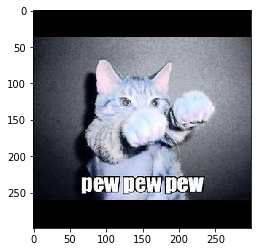

In [49]:
plt.imshow(Image.open(testFileName))
print(evaluate(model, testFileName))

{'class': 'dog', 'confidence': '0.999278'}


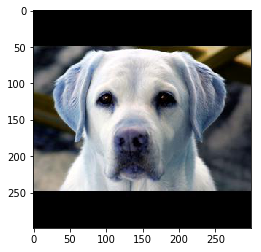

In [53]:
#test_img_url = 'http://images1.fanpop.com/images/image_uploads/Funny-Cat-Pictures-cats-935656_500_375.jpg' # sample cat image
test_img_url = 'http://www.petmeds.org/wp-content/uploads/2012/01/7247801_081708_DSC_0937.jpg' # sample dog image
with urllib.request.urlopen(test_img_url) as response, open(testFileName, 'wb') as out_file:
        data = response.read() # a `bytes` object
        out_file.write(data)
        
resize_eq(testFileName)

plt.imshow(Image.open(testFileName))
print(evaluate(model, testFileName))